In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import timm  # Make sure to install the timm module (e.g., pip install timm)
import os
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/Users/maniksinghsarmaal/Downloads/s_bin/Sbin_f/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
#print(class_names)
device = torch.device("mps")
#print(device)

vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)
# change the number of classes 
vgg16.classifier[6].out_features = len(class_names)
# freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = False
    
# optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()


In [39]:
#print(vgg16)

In [4]:

def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy


# training function
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy


In [5]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(10):
    train_epoch_loss, train_epoch_accuracy = fit(vgg16, dataloaders['train'])
    val_epoch_loss, val_epoch_accuracy = validate(vgg16, dataloaders['val'])
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')

Train Loss: 0.2169, Train Acc: 78.49
Train Loss: 0.1163, Train Acc: 86.17
Train Loss: 0.0954, Train Acc: 86.63
Train Loss: 0.0899, Train Acc: 88.25
Train Loss: 0.0773, Train Acc: 89.59
Train Loss: 0.0704, Train Acc: 90.93
Train Loss: 0.0598, Train Acc: 91.72
Train Loss: 0.0530, Train Acc: 92.78
Train Loss: 0.0585, Train Acc: 91.54
Train Loss: 0.0522, Train Acc: 92.78
33.620321452617645 minutes


In [6]:
validate(vgg16, dataloaders['val'])

(0.015512490561546858, 97.27272727272727)

In [10]:
# After training your model and fine-tuning
import torch.onnx  # Install if not already

# Replace with your actual device
device = 'cpu'   # Use 'cpu' for ESP32 compatibility

# Export to ONNX
torch.onnx.export(
    model=vgg16.to(device),  # Move model to device
    args=torch.randn(1, 3, 224, 224).to(device),  # Dummy input tensor (adjust size)
    f="model.onnx",
    opset_version=11,  # Adjust for compatibility
)


In [54]:
import onnxruntime
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

# Define the path to the ONNX model file
onnx_model_path = "model.onnx"

# Define the transformation for test images
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = data_transforms(image).unsqueeze(0)  # Add batch dimension
    return image.numpy()

# Function to predict using the ONNX model
def predict_image(image_path, model_path):
    # Load the ONNX model
    ort_session = onnxruntime.InferenceSession(model_path)

    # Get the input name expected by the model
    input_name = ort_session.get_inputs()[0].name

    # Preprocess the input image
    input_data = preprocess_image(image_path)

    # Run inference using ONNX runtime
    output = ort_session.run(None, {input_name: input_data.astype(np.float32)})

    # Get the predicted class index
    predicted_class_index = np.argmax(output)

    return predicted_class_index
    
# Example usage: Predict a new image
image_path = "/Users/maniksinghsarmaal/Downloads/scwvc.jpeg"
predictions = predict_image(image_path, onnx_model_path)
print("Predicted Class Index:", predictions)

Predicted Class Index: 1


In [4]:
import onnx
import onnxruntime

# Load the ONNX model
onnx_model = onnx.load("model.onnx")

# Create an inference session with onnxruntime
session = onnxruntime.InferenceSession("model.onnx")

# Get the input names and shapes
input_details = session.get_inputs()
input_names = [input_detail.name for input_detail in input_details]
input_shapes = [input_detail.shape for input_detail in input_details]

print("Input Names:", input_names)
print("Input Shapes:", input_shapes)


Input Names: ['input.1']
Input Shapes: [[1, 3, 224, 224]]


In [9]:
pip install  onnx-tf==1.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 2.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: onnx-tf
    Found existing installation: onnx-tf 1.10.0
    Uninstalling onnx-tf-1.10.0:
      Successfully uninstalled onnx-tf-1.10.0
Note: you may need to restart the kernel to use updated packages.


In [11]:
onnx-tf convert -i model.onnx -o model.pb


SyntaxError: invalid syntax (1644001435.py, line 1)

In [40]:
#testing
import matplotlib.pyplot as plt
from PIL import Image

def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    # Open the image
    img = Image.open(img_path)

    # Apply transformations
    img_transformed = data_transforms['val'](img)

    # Prepare the image tensor for prediction
    img_tensor = img_transformed.unsqueeze(0).to(device)

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Predict the class
    with torch.no_grad():
        outputs = model(img_tensor)
        _, preds = torch.max(outputs, 1)
        print(f'Predicted Class is: {class_names[preds[0]]}')

    # Set the model back to its original mode
    model.train(mode=was_training)


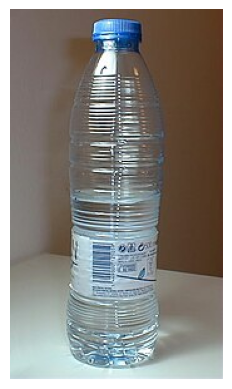

Predicted Class is: Inorganic


In [41]:
visualize_model_predictions(vgg16,'/Users/maniksinghsarmaal/Downloads/bottle.jpg')

In [55]:
print(len(class_names))

3


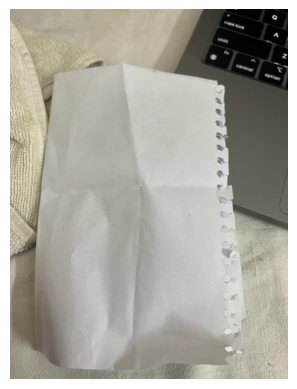

Predicted Class is: Organic


In [42]:
visualize_model_predictions(vgg16,'/Users/maniksinghsarmaal/Downloads/2.jpeg')

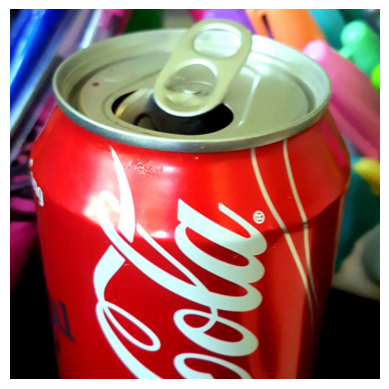

Predicted Class is: metal


In [43]:
visualize_model_predictions(vgg16,'/Users/maniksinghsarmaal/Downloads/can.jpg.webp')

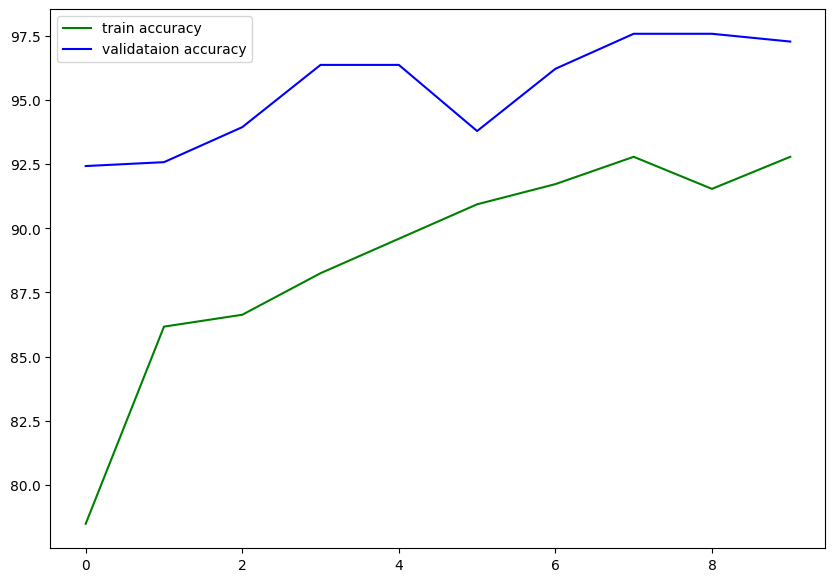

In [44]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

In [39]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [45]:
torch.save(vgg16.state_dict(), '/Users/maniksinghsarmaal/Downloads/s_bin/Sbin_f/vgg16.pth')

In [45]:
state = {
    'epoch': epoch,
    'state_dict': vgg16.state_dict(),
    'optimizer': optimizer.state_dict()
}
torch.save(state, '/Users/maniksinghsarmaal/Downloads/s_bin/Sbin_f/saved_model/model.pth')